<a href="https://colab.research.google.com/github/borisvel/6.7830FinalProject/blob/main/6_7830Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
from datetime import datetime
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
from google.colab import files

In [ ]:
codes_to_states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

states_to_codes = {codes_to_states[code] : code for code in codes_to_states}

In [ ]:
previous = pd.read_csv("2012results.csv", thousands=',')

In [ ]:
previous = previous[["State", "Obama (D)", "Romney (R)"]][:51]

In [ ]:
previous["proportion"] = previous["Obama (D)"]/(previous["Obama (D)"] + previous["Romney (R)"])

In [ ]:
past_results = {}
for i in range(previous.shape[0]):
  past_results[previous.loc[i, "State"]] = previous.loc[i, "proportion"]

In [ ]:
polls = pd.read_csv("2016polls.csv")

In [ ]:
polls = polls.rename(columns = {'start_date':'startdate', 'end_date':'enddate', 'Obama (D)':'rawpoll_clinton', 'Romney (R)':'rawpoll_trump', 'Sample':'samplesize', 'Pollster':'pollster', 'State':'state'})

In [ ]:
polls.head()

,Unnamed: 0,state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin
0,1,U.S.,2016-11-03,2016-11-06,ABC News/Washington Post,A+,2220.0,lv,47.00,43.00,4.00,NaN,45.20163,41.72430,4.626221,NaN
1,2,U.S.,2016-11-01,2016-11-07,Google Consumer Surveys,B,26574.0,lv,38.03,35.69,5.46,NaN,43.34557,41.21439,5.175792,NaN
2,3,U.S.,2016-11-02,2016-11-06,Ipsos,A-,2195.0,lv,42.00,39.00,6.00,NaN,42.02638,38.81620,6.844734,NaN
3,4,U.S.,2016-11-04,2016-11-07,YouGov,B,3677.0,lv,45.00,41.00,5.00,NaN,45.65676,40.92004,6.069454,NaN
4,5,U.S.,2016-11-03,2016-11-06,Gravis Marketing,B-,16639.0,rv,47.00,43.00,3.00,NaN,46.84089,42.33184,3.726098,NaN


In [ ]:
SWING_STATES = ["Wisconsin", "Pennsylvania", "New Hampshire", "Minnesota", "Arizona", "Florida", "Michigan", "Nevada", "North Carolina", "Maine", "Vermont", "Georgia", "Colorado"]
#SWING_STATES = codes_to_states.keys()
#SWING_STATES = ["California"]
SWING_STATES_CODES = [states_to_codes[state] for state in SWING_STATES]
#SWING_STATES_CODES = SWING_STATES

In [ ]:
pollsters = set(polls['pollster'])
good_pollsters = []
for pollster in pollsters:
  if polls[polls['pollster'] == pollster].shape[0] >= 800: good_pollsters.append(pollster)

In [ ]:
decided_per_pollster = {}
for pollster in pollsters:
  temp = polls[polls['pollster'] == pollster]
  decided_per_pollster[pollster] = ((temp['rawpoll_clinton'] + temp['rawpoll_trump'])/100).reset_index(drop=True)

In [ ]:
#polls.drop(columns = ["Unnamed: 0", "MoE", "Spread", "obama_spread"], inplace=True)
polls.drop(columns = ["Unnamed: 0", "grade", "population", "rawpoll_johnson", "rawpoll_mcmullin", "adjpoll_clinton", "adjpoll_trump", "adjpoll_johnson", "adjpoll_mcmullin"], inplace=True)
#polls = polls[polls["state"] != "U.S."]
polls = polls[polls["state"].isin(SWING_STATES)]
#polls = polls[polls['pollster'].isin(good_pollsters)]
polls["startdate"] = pd.to_datetime(polls["startdate"])
polls["enddate"] = pd.to_datetime(polls["enddate"])
polls.sort_values(by="enddate", inplace=True, ignore_index=True)
polls = polls[polls["enddate"] > datetime(2016, 8, 8)]
#removal = np.random.choice(polls.index, 3*polls.shape[0]//4, replace=False)
#polls = polls.drop(removal)
first_poll_ending = min(polls["enddate"])
election_day = datetime(2016, 11, 8)
timeframe = int((election_day - first_poll_ending).days) + 1

<ipython-input-14-26f9cf69d3bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polls["startdate"] = pd.to_datetime(polls["startdate"])
<ipython-input-14-26f9cf69d3bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polls["enddate"] = pd.to_datetime(polls["enddate"])
<ipython-input-14-26f9cf69d3bd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [ ]:
polls.isna().sum().sum()

0

In [ ]:
polls.dropna(inplace=True)
polls = polls.reset_index(drop=True)

In [ ]:
polls.head()

,state,startdate,enddate,pollster,samplesize,rawpoll_clinton,rawpoll_trump
0,North Carolina,2016-08-04,2016-08-10,Marist College,921.0,45.0,36.0
1,Colorado,2016-08-04,2016-08-10,Marist College,899.0,41.0,29.0
2,Florida,2016-08-04,2016-08-10,Marist College,862.0,41.0,36.0
3,Florida,2016-08-10,2016-08-10,Opinion Savvy/InsiderAdvantage,622.0,45.2,44.3
4,Michigan,2016-08-09,2016-08-10,Mitchell Research & Communications,1314.0,44.0,33.0


In [ ]:
states = sorted(list(set(polls["state"])))
polls_per_state = {}

In [ ]:
for state in states:
    polls_per_state[state] = polls[polls["state"] == state].reset_index(drop=True)

In [ ]:
present = np.zeros((timeframe, len(states)))
Y = []
for i in range(timeframe):
    Y.append([])
    for j in range(len(states)):
        Y[-1].append([])
        
for idx, state in enumerate(states):
    for i in range(polls_per_state[state].shape[0]):
        day_since_start = int((polls_per_state[state].loc[i, "enddate"] - first_poll_ending).days)
        democrat = polls_per_state[state].loc[i, "rawpoll_clinton"]
        republican = polls_per_state[state].loc[i, "rawpoll_trump"]
        prefer_someone = int((polls_per_state[state].loc[i, "samplesize"])*(democrat + republican)/100)
        if prefer_someone > polls_per_state[state].loc[i, "samplesize"]: print(democrat + republican)
        Y[day_since_start][idx].append((int(democrat*polls_per_state[state].loc[i, "samplesize"]/100), prefer_someone, polls_per_state[state].loc[i, "samplesize"]))
        present[day_since_start][idx] = 1

In [ ]:
h = np.array([past_results[states_to_codes[state]] for state in states])
s = np.zeros(len(states)) + 6
past = 14
day = timeframe - past
final_decided = np.zeros(len(states)) + 0.99
decided_s = np.zeros(len(states)) + 1

y_obs = []
total = []
decided = []
cs = []

for i in range(day):
    for j in range(len(states)):
        for poll in Y[i][j]:
            decided.append(poll[1])
            y_obs.append(poll[0])
            total.append(poll[2])
            cs.append((i, j))
            
y_obs = np.array(y_obs)
decided = np.array(decided)
total = np.array(total)

In [ ]:
state = 12
days = []
support = []
means = []
means_running = []
days_running = []
days_single = []
medians = []
for i in range(timeframe):
  temp = []
  for poll in Y[i][state]:
    days.append(i)
    support.append(poll[0]/poll[1])
    temp.append(poll[0]/poll[1])
  if len(Y[i][state]) > 0:
    means.append(np.mean(temp))
    days_single.append(i)
    medians.append(np.median(temp))

for i in range(timeframe):
  temp = []
  for j in range(max(0, i-20), i + 1):
      for poll in Y[j][state]:
        temp.append(poll[0]/poll[1])
  if len(temp) > 0:
    means_running.append(np.mean(temp))
    days_running.append(i)

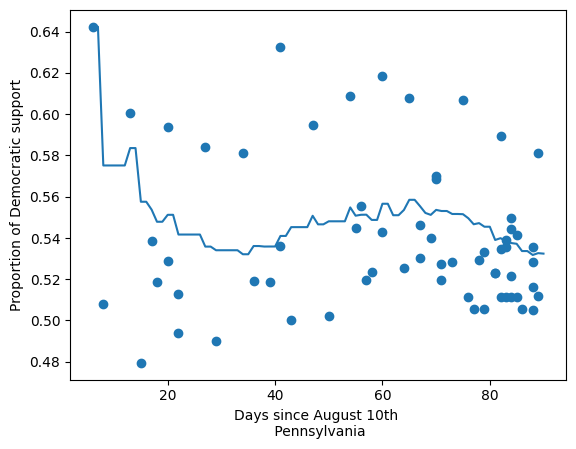

In [ ]:
plt.scatter(days, support)
plt.plot(days_running, means_running)
plt.xlabel("Days since August 10th \n Pennsylvania")
plt.ylabel("Proportion of Democratic support")
plt.show()

In [ ]:
with pm.Model() as voting_model:
    
    #priors
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)
    sigma_delta = pm.HalfNormal("sigma_delta", sigma=1)
    
    #random walk
    GRWD = pm.GaussianRandomWalk("deltaRW", mu = 0, sigma = sigma_delta, shape=(timeframe, 1), init_dist = pm.Normal.dist(0, 1e-6))
    GRWB = pm.MvGaussianRandomWalk("betaRW", 
                                 mu = np.zeros(len(states)), 
                                 cov = np.identity(len(states))*sigma_beta, 
                                 shape=(timeframe, len(states)), 
                                 init_dist = pm.MvNormal.dist(mu = pm.math.logit(h), cov = np.diag(s), shape=(len(states)))
                                  )
    
    #modelling pi
    pi = pm.Deterministic("pi", var = pm.math.invlogit(GRWD + GRWB))
    
    #what we observe
    pi_obs = []
    for c in cs:
        pi_obs.append(pi[timeframe - 1 - c[0]][c[1]])
    pi_obs = pt.as_tensor_variable(pi_obs)
    y = pm.Binomial("y", p=pi_obs, n=decided, shape=(len(cs)), observed=y_obs)

In [ ]:
"""
with pm.Model() as decided_model:
    
    #priors
    sigma_gamma = pm.HalfNormal("sigma_gamma", sigma=1)
    sigma_eta = pm.HalfNormal("sigma_eta", sigma=1)
    
    #random walk
    GRWE = pm.GaussianRandomWalk("etaRW", mu = 0, sigma = sigma_eta, shape=(timeframe, 1), init_dist = pm.Normal.dist(0, 1e-6))
    GRWG = pm.MvGaussianRandomWalk("gammaRW", 
                                 mu = np.zeros(len(states)), 
                                 cov = np.identity(len(states))*sigma_gamma, 
                                 shape=(timeframe, len(states)), 
                                 init_dist = pm.MvNormal.dist(mu = pm.math.logit(final_decided), cov = np.diag(decided_s), shape=(len(states)))
                                  )
  
    #modelling pi
    pi_decided = pm.Deterministic("pi_decided", var = pm.math.invlogit(GRWG + GRWE))
    
    
    #what we observe
    pi_decided_obs = []
    for c in cs:
        pi_decided_obs.append(pi_decided[timeframe - 1 - c[0]][c[1]])
    pi_decided_obs = pt.as_tensor_variable(pi_decided_obs)
    d = pm.Binomial("d", p=pi_decided_obs, n=total, shape =(len(cs)), observed = decided)
  """

In [ ]:
"""
with pm.Model() as voting_model_updated:
    
    #priors
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)
    sigma_delta = pm.HalfNormal("sigma_delta", sigma=1)
    #r = pm.Uniform("rho", lower = 1, upper = 3, shape=(1, len(states)))
    #sigma_ar = pm.HalfNormal("sigma_ar", sigma=1)
    
    #random walk
    GRWD = pm.GaussianRandomWalk("deltaRW", mu = 0, sigma = sigma_delta, shape=(timeframe, 1), init_dist = pm.Normal.dist(0, 1e-6))
    GRWB = pm.MvGaussianRandomWalk("betaRW", 
                                 mu = np.zeros(len(states)), 
                                 cov = np.identity(len(states))*sigma_beta, 
                                 shape=(timeframe, len(states)), 
                                 init_dist = pm.MvNormal.dist(mu = pm.math.logit(h), cov = np.diag(s), shape=(len(states)))
                                  )
    
    #autoregressive
    autoreg = pm.AR('ar_walk', 
                    rho=r,
                    sigma=sigma_ar, 
                    shape = (timeframe, len(states)), 
               init_dist = pm.MvNormal.dist(mu = np.zeros(len(states)), cov = np.identity(len(states))*(1e-6), shape=(len(states)))
              )
    
    
    #modelling pi
    pi = pm.Deterministic("pi", var = pm.math.invlogit(GRWB + GRWD))
    
    #what we observe
    pi_obs = []
    for c in cs:
        pi_obs.append(pi[timeframe - 1 - c[0]][c[1]])
    pi_obs = pt.as_tensor_variable(pi_obs)
    ud = pm.Binomial("y", p=pi_obs, n=total, shape = (len(cs)), observed = y_obs)
  """

In [ ]:
pm.model_to_graphviz(voting_model)

In [ ]:
pm.model_to_graphviz(decided_model)

In [ ]:
pm.model_to_graphviz(voting_model_updated)

In [ ]:
with voting_model:
    trace_voting = pm.sample(draws=500, tune=500, cores=2)

In [ ]:
#with decided_model:
#    trace_decided = pm.sample(draws=500, tune=500, cores=2)

In [ ]:
#with voting_model_updated:
#    trace_voting_updated = pm.sample(draws=500, tune=500, cores=2)

In [ ]:
data_voting = az.summary(trace_voting)
data_voting.to_csv("2012d14voting.csv")
files.download("2012d14votingtest.csv")

In [ ]:
#data_decided = az.summary(trace_decided)
#data_decided.to_csv("2016d14decided.csv")
#files.download("2016d14decided.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#data_undecided = az.summary(trace_voting_updated)
#data_undecided.to_csv("2016d14votingupdated.csv")
#files.download("2016d14votingupdated.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
processed = pd.read_csv("2016d14voting.csv")

In [ ]:
processed

,Unnamed: 0,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,"deltaRW[0, 0]",-0.000,0.000,-0.000,0.000,0.000,0.000,811.0,641.0,1.00
1,"deltaRW[1, 0]",0.000,0.000,-0.000,0.000,0.000,0.000,893.0,442.0,1.00
2,"deltaRW[2, 0]",0.000,0.000,-0.000,0.000,0.000,0.000,861.0,598.0,1.00
3,"deltaRW[3, 0]",0.000,0.000,-0.000,0.000,0.000,0.000,934.0,355.0,1.00
4,"deltaRW[4, 0]",-0.000,0.000,-0.000,0.000,0.000,0.000,978.0,580.0,1.00
...,...,...,...,...,...,...,...,...,...,...
2454,"pi[90, 8]",0.551,0.016,0.519,0.580,0.000,0.000,1444.0,986.0,1.00
2455,"pi[90, 9]",0.524,0.014,0.495,0.549,0.003,0.002,27.0,861.0,1.05
2456,"pi[90, 10]",0.536,0.018,0.499,0.568,0.000,0.000,1401.0,173.0,1.03
2457,"pi[90, 11]",0.701,0.027,0.655,0.755,0.005,0.004,30.0,26.0,1.05


In [ ]:
processed.rename(columns = {"Unnamed: 0": "Parameter"}, inplace=True)

In [ ]:
state = 10
results = []
std_upper = []
std_lower = []
for i in range(timeframe):
  name1 = "pi[" + str(timeframe - 1 - i) + ", " + str(state) + "]"
  row1 = processed[processed["Parameter"] == name1]
  results.append(processed.loc[row1.index[0], "mean"])
  std_upper.append(processed.loc[row1.index[0], "mean"] + 2*processed.loc[row1.index[0], "sd"])
  std_lower.append(processed.loc[row1.index[0], "mean"] - 2*processed.loc[row1.index[0], "sd"])

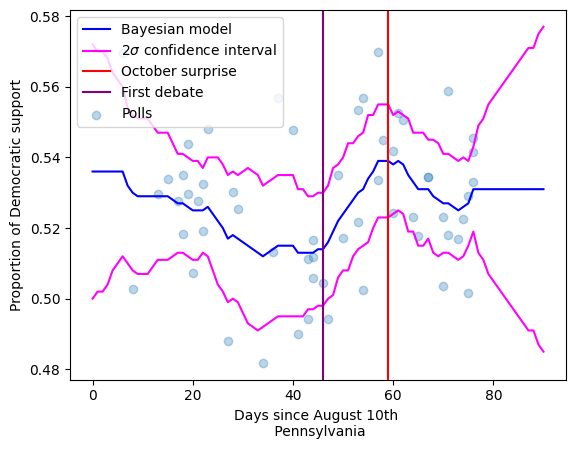

In [ ]:
plt.plot(range(timeframe), results, label = "Bayesian model", c='blue')
plt.plot(range(timeframe), std_upper, label = "2$\sigma$ confidence interval", c='magenta')
plt.plot(range(timeframe), std_lower, c='magenta')
plt.axvline(x = timeframe-32, c='red', label="October surprise")
plt.axvline(x = timeframe-45, c='purple', label="First debate")
plt.scatter(days, support, label = "Polls", alpha=0.3)
plt.legend()
plt.xlabel("Days since August 10th \n Pennsylvania")
plt.ylabel("Proportion of Democratic support")
plt.show()